In [4]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import os

df = pd.read_csv('spike_fubar.tsv', sep='\t')
for col in df.columns:
    if 'amino_counts' in col:
        df[col] = df[col].apply(lambda s: ast.literal_eval(s))

In [2]:
prob_pairs = {}
for col in df.columns:
    if 'Prob[alpha<beta]' in col:
        key = col.split('_')[0]
        prob_pairs.setdefault(key, []).append(col)

for key, value in list(prob_pairs.items()):
    if len(value) != 2:
        del prob_pairs[key]

In [ ]:
os.makedirs('visualizations/DeltaB16172like_Spike/per_month', exist_ok=True)

for date, (vacced_col, unvacced_col) in prob_pairs.items():
    conditions = [(df[vacced_col] >= 0.9) & (df[unvacced_col] >= 0.9), (df[vacced_col] >= 0.9) & (df[unvacced_col] < 0.9), (df[vacced_col] < 0.9) & (df[unvacced_col] >= 0.9)]
    choices = ['purple', 'blue', 'red']
    df['plot_colors'] = np.select(conditions, choices, default='black')
    df['plot_size'] = [5 if val != 'black' else 0.5 for val in df['plot_colors']]
    df['plot_labels'] = [pos if val in ['red', 'blue'] else -1 for val, pos in zip(df['plot_colors'], df['Position_in_reference'])]
    
    colors = ['red' if val >= 0.9 else 'black' for val in df[vacced_col]]
    plt.figure(figsize=(9, 9))
    plt.scatter(df[vacced_col], df[unvacced_col], s=df['plot_size'], c=df['plot_colors'])
    plt.hlines(0.9, -0.05, 1.05, linewidth=1, linestyles='dashed', colors='black')
    plt.vlines(0.9, -0.05, 1.05, linewidth=1, linestyles='dashed', colors='black')
    plt.title('Spike Protein - Positive Selection Comparison by Position')
    plt.xlabel('Probabilty of positive Selection (Vaccinated)')
    plt.ylabel('Probabilty of positive Selection (Unvaccinated)')

    plt.axhspan(0.9, 1.05, color='red', alpha=0.3, edgecolor=None)
    plt.axvspan(0.9, 1.05, color='blue', alpha=0.3, edgecolor=None)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    text_labels = []
    for x, y, pos, amino_counts_ja, amino_counts_nein in zip(df[vacced_col], df[unvacced_col], df['plot_labels'], df[f'{date}_amino_counts_Ja'], df[f'{date}_amino_counts_Nein']):
        if pos != -1:
            text_labels.append(plt.text(x, y, pos, fontsize=8))
    adjust_text(text_labels)
    plt.savefig(f'visualizations/DeltaB16172like_Spike/per_month/{date}.svg')

In [6]:
os.makedirs('visualizations/DeltaB16172like_Spike/per_position', exist_ok=True)

vacced_columns = [col for col in df.columns if 'Prob[alpha<beta]_Ja' in col]
unvacced_columns = [col for col in df.columns if 'Prob[alpha<beta]_Nein' in col]
vacced_dates = sorted(set([col.split('_')[0] for col in vacced_columns]))
unvacced_dates = sorted(set([col.split('_')[0] for col in unvacced_columns]))
for (vacced_idx, vacced_row), (unvacced_idx, unvacced_row) in zip(df[vacced_columns].iterrows(), df[unvacced_columns].iterrows()):
    plt.figure(figsize=(9, 9))
    plt.plot(vacced_dates, vacced_row, c='blue', label='Vaccinated')
    plt.plot(unvacced_dates, unvacced_row, c='red', label='Unvaccinated')
    plt.ylim(-0.05, 1.05)
    plt.xticks(rotation=45)
    plt.title(f'Spike Protein - Positive Selection Comparison - Position: {vacced_idx+1}')
    plt.xlabel('Calender Month')
    plt.ylabel('Probabilty of positive Selection')
    plt.legend()
    plt.savefig(f'visualizations/DeltaB16172like_Spike/per_position/{vacced_idx+1}.svg')
    plt.close()



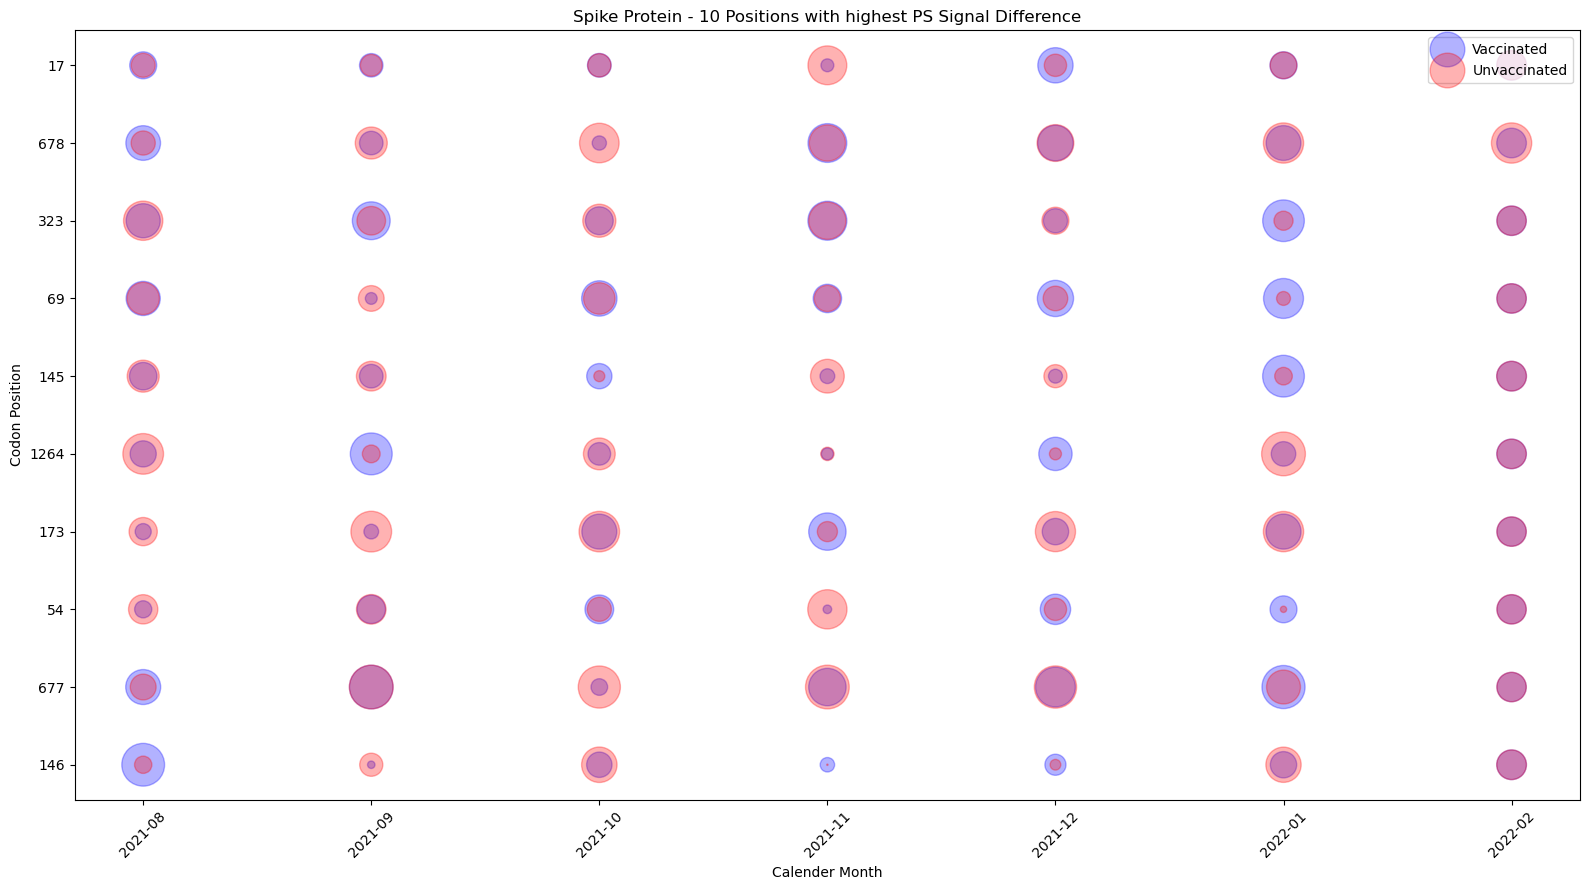

In [52]:
df_top10 = df.sort_values(by='[alpha<beta]_max_diff', ascending=False).head(10).reset_index(drop=True)
vacced_cols = [col for col in df_top10.columns if col.endswith('Prob[alpha<beta]_Ja')]
unvacced_cols = [col for col in df_top10.columns if col.endswith('Prob[alpha<beta]_Nein')][:-1]

plt.figure(figsize=(16, 9))

for col in vacced_cols:
    date = col.split('_')[0]
    plt.scatter([date]*len(df_top10[col]), df_top10[col].index, s=df_top10[col]*1000, c='blue', alpha=0.3, label='vaccinated')

for col in unvacced_cols:
    date = col.split('_')[0]
    plt.scatter([date]*len(df_top10[col]), df_top10[col].index, s=df_top10[col]*1000, c='red', alpha=0.3, label='unvaccinated')

plt.title('Spike Protein - 10 Positions with highest PS Signal Difference')
plt.xticks(rotation=45)
plt.xlabel('Calender Month')
plt.ylabel('Codon Position')
ax = plt.gca()
ax.set_yticks(range(len(df_top10)))
ax.set_yticklabels(df_top10['Position_in_reference'])


import matplotlib.lines as mlines
blue_dot = mlines.Line2D([], [], color='blue', alpha=0.3, marker='o', linestyle='None',
                         markersize=25, label='Vaccinated')
red_dot = mlines.Line2D([], [], color='red', alpha=0.3, marker='o', linestyle='None',
                         markersize=25, label='Unvaccinated')

# Add legend with custom entries
plt.legend(handles=[blue_dot, red_dot], loc='upper right')
plt.tight_layout()